In [1]:
import torch
import timm
import time
import torch.nn as nn
import numpy as np
import torch_tensorrt
from modules import repvgg_dbb_super_tiny, VQEmbedding, repvgg_model_convert

In [2]:
def benchmark(model, input_shape=(1024, 3, 512, 512), dtype='fp32', nwarmup=50, nruns=1000, thoughput_list=[], device='cpu'):
    input_data = torch.randn(input_shape)
    input_data = input_data.to(device)
    if dtype=='fp16':
        input_data = input_data.half()
        
    print("Warm up ...")
    with torch.no_grad():
        for _ in range(nwarmup):
            features = model(input_data)
    torch.cuda.synchronize()
    print("Start timing ...")
    timings = []
    with torch.no_grad():
        for i in range(1, nruns+1):
            start_time = time.time()
            pred_loc  = model(input_data)
            torch.cuda.synchronize()
            end_time = time.time()
            timings.append(end_time - start_time)
            if i%10==0:
                print('Iteration %d/%d, avg batch time %.2f ms'%(i, nruns, np.mean(timings)*1000))

    print("Input shape:", input_data.size())
    print('Average throughput: %.2f images/second'%(input_shape[0]/np.mean(timings)))
    thoughput_list.append(input_shape[0]/np.mean(timings))

In [3]:
from torchinfo import summary
model = repvgg_dbb_super_tiny()
# summary(model, input_size=[1, 3, 32, 32])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:

modelB = repvgg_model_convert(model)
modelB.eval()
modelB.classifier = nn.Identity()

modelB = modelB.to(device)
trt_ts_module = torch_tensorrt.compile(modelB, 
    inputs= [torch_tensorrt.Input((1, 3, 32, 32))],
    enabled_precisions= { torch.float} # Run with FP16
)



In [10]:
batch_size_list = [2**i for i in range(11)]
time_list = []
time_list_after = []
for b in batch_size_list:
    modelB = repvgg_model_convert(model)
    modelB.eval()
    modelB.classifier = nn.Identity()

    modelB = modelB.to(device)
    trt_ts_module = torch_tensorrt.compile(modelB, 
        inputs= [torch_tensorrt.Input((1, 3, 32, 32))],
        enabled_precisions= { torch.float} # Run with FP16
    )
    
    
    modelC = repvgg_model_convert(model)
    modelC.eval()
    modelC = modelC.to(device)
    trt_ts_moduleC = torch_tensorrt.compile(modelC,
        inputs= [torch_tensorrt.Input((32, 3, 32, 32))],
        enabled_precisions= { torch.float} # Run with FP16
    )

    
    benchmark(modelB, input_shape=(b, 3, 32, 32), thoughput_list=time_list, device=device)
    benchmark(modelC, input_shape=(b, 3, 32, 32), thoughput_list=time_list_after, device=device)

Warm up ...
Start timing ...
Iteration 10/1000, avg batch time 0.29 ms
Iteration 20/1000, avg batch time 0.28 ms
Iteration 30/1000, avg batch time 0.28 ms
Iteration 40/1000, avg batch time 0.28 ms
Iteration 50/1000, avg batch time 0.28 ms
Iteration 60/1000, avg batch time 0.28 ms
Iteration 70/1000, avg batch time 0.28 ms
Iteration 80/1000, avg batch time 0.28 ms
Iteration 90/1000, avg batch time 0.28 ms
Iteration 100/1000, avg batch time 0.28 ms
Iteration 110/1000, avg batch time 0.28 ms
Iteration 120/1000, avg batch time 0.28 ms
Iteration 130/1000, avg batch time 0.28 ms
Iteration 140/1000, avg batch time 0.28 ms
Iteration 150/1000, avg batch time 0.28 ms
Iteration 160/1000, avg batch time 0.28 ms
Iteration 170/1000, avg batch time 0.28 ms
Iteration 180/1000, avg batch time 0.28 ms
Iteration 190/1000, avg batch time 0.28 ms
Iteration 200/1000, avg batch time 0.28 ms
Iteration 210/1000, avg batch time 0.28 ms
Iteration 220/1000, avg batch time 0.28 ms
Iteration 230/1000, avg batch time

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Iteration 20/1000, avg batch time 0.37 ms
Iteration 30/1000, avg batch time 0.37 ms
Iteration 40/1000, avg batch time 0.36 ms
Iteration 50/1000, avg batch time 0.36 ms
Iteration 60/1000, avg batch time 0.35 ms
Iteration 70/1000, avg batch time 0.35 ms
Iteration 80/1000, avg batch time 0.35 ms
Iteration 90/1000, avg batch time 0.35 ms
Iteration 100/1000, avg batch time 0.35 ms
Iteration 110/1000, avg batch time 0.35 ms
Iteration 120/1000, avg batch time 0.35 ms
Iteration 130/1000, avg batch time 0.35 ms
Iteration 140/1000, avg batch time 0.35 ms
Iteration 150/1000, avg batch time 0.35 ms
Iteration 160/1000, avg batch time 0.35 ms
Iteration 170/1000, avg batch time 0.35 ms
Iteration 180/1000, avg batch time 0.35 ms
Iteration 190/1000, avg batch time 0.35 ms
Iteration 200/1000, avg batch time 0.35 ms
Iteration 210/1000, avg batch time 0.35 ms
Iteration 220/1000, avg batch time 0.35 ms
Iteration 230/1000, avg batch time 0.35 ms
Iteration 240/1000, avg batch time 0.34 ms
Iteration 250/1000,

Warm up ...
Start timing ...
Iteration 10/1000, avg batch time 0.28 ms
Iteration 20/1000, avg batch time 0.28 ms
Iteration 30/1000, avg batch time 0.28 ms
Iteration 40/1000, avg batch time 0.28 ms
Iteration 50/1000, avg batch time 0.28 ms
Iteration 60/1000, avg batch time 0.28 ms
Iteration 70/1000, avg batch time 0.28 ms
Iteration 80/1000, avg batch time 0.28 ms
Iteration 90/1000, avg batch time 0.28 ms
Iteration 100/1000, avg batch time 0.28 ms
Iteration 110/1000, avg batch time 0.28 ms
Iteration 120/1000, avg batch time 0.28 ms
Iteration 130/1000, avg batch time 0.28 ms
Iteration 140/1000, avg batch time 0.28 ms
Iteration 150/1000, avg batch time 0.28 ms
Iteration 160/1000, avg batch time 0.28 ms
Iteration 170/1000, avg batch time 0.28 ms
Iteration 180/1000, avg batch time 0.28 ms
Iteration 190/1000, avg batch time 0.28 ms
Iteration 200/1000, avg batch time 0.28 ms
Iteration 210/1000, avg batch time 0.28 ms
Iteration 220/1000, avg batch time 0.28 ms
Iteration 230/1000, avg batch time

Warm up ...
Start timing ...
Iteration 10/1000, avg batch time 0.26 ms
Iteration 20/1000, avg batch time 0.26 ms
Iteration 30/1000, avg batch time 0.26 ms
Iteration 40/1000, avg batch time 0.26 ms
Iteration 50/1000, avg batch time 0.26 ms
Iteration 60/1000, avg batch time 0.26 ms
Iteration 70/1000, avg batch time 0.26 ms
Iteration 80/1000, avg batch time 0.26 ms
Iteration 90/1000, avg batch time 0.26 ms
Iteration 100/1000, avg batch time 0.26 ms
Iteration 110/1000, avg batch time 0.26 ms
Iteration 120/1000, avg batch time 0.26 ms
Iteration 130/1000, avg batch time 0.26 ms
Iteration 140/1000, avg batch time 0.26 ms
Iteration 150/1000, avg batch time 0.26 ms
Iteration 160/1000, avg batch time 0.26 ms
Iteration 170/1000, avg batch time 0.26 ms
Iteration 180/1000, avg batch time 0.26 ms
Iteration 190/1000, avg batch time 0.26 ms
Iteration 200/1000, avg batch time 0.26 ms
Iteration 210/1000, avg batch time 0.26 ms
Iteration 220/1000, avg batch time 0.26 ms
Iteration 230/1000, avg batch time

Warm up ...
Start timing ...
Iteration 10/1000, avg batch time 0.28 ms
Iteration 20/1000, avg batch time 0.27 ms
Iteration 30/1000, avg batch time 0.27 ms
Iteration 40/1000, avg batch time 0.27 ms
Iteration 50/1000, avg batch time 0.27 ms
Iteration 60/1000, avg batch time 0.27 ms
Iteration 70/1000, avg batch time 0.27 ms
Iteration 80/1000, avg batch time 0.26 ms
Iteration 90/1000, avg batch time 0.26 ms
Iteration 100/1000, avg batch time 0.26 ms
Iteration 110/1000, avg batch time 0.26 ms
Iteration 120/1000, avg batch time 0.26 ms
Iteration 130/1000, avg batch time 0.26 ms
Iteration 140/1000, avg batch time 0.26 ms
Iteration 150/1000, avg batch time 0.26 ms
Iteration 160/1000, avg batch time 0.26 ms
Iteration 170/1000, avg batch time 0.26 ms
Iteration 180/1000, avg batch time 0.26 ms
Iteration 190/1000, avg batch time 0.26 ms
Iteration 200/1000, avg batch time 0.26 ms
Iteration 210/1000, avg batch time 0.26 ms
Iteration 220/1000, avg batch time 0.26 ms
Iteration 230/1000, avg batch time

Warm up ...
Start timing ...
Iteration 10/1000, avg batch time 0.28 ms
Iteration 20/1000, avg batch time 0.28 ms
Iteration 30/1000, avg batch time 0.28 ms
Iteration 40/1000, avg batch time 0.28 ms
Iteration 50/1000, avg batch time 0.28 ms
Iteration 60/1000, avg batch time 0.28 ms
Iteration 70/1000, avg batch time 0.28 ms
Iteration 80/1000, avg batch time 0.28 ms
Iteration 90/1000, avg batch time 0.28 ms
Iteration 100/1000, avg batch time 0.28 ms
Iteration 110/1000, avg batch time 0.28 ms
Iteration 120/1000, avg batch time 0.28 ms
Iteration 130/1000, avg batch time 0.28 ms
Iteration 140/1000, avg batch time 0.28 ms
Iteration 150/1000, avg batch time 0.28 ms
Iteration 160/1000, avg batch time 0.28 ms
Iteration 170/1000, avg batch time 0.28 ms
Iteration 180/1000, avg batch time 0.28 ms
Iteration 190/1000, avg batch time 0.28 ms
Iteration 200/1000, avg batch time 0.28 ms
Iteration 210/1000, avg batch time 0.28 ms
Iteration 220/1000, avg batch time 0.28 ms
Iteration 230/1000, avg batch time

Warm up ...
Start timing ...
Iteration 10/1000, avg batch time 0.30 ms
Iteration 20/1000, avg batch time 0.29 ms
Iteration 30/1000, avg batch time 0.29 ms
Iteration 40/1000, avg batch time 0.29 ms
Iteration 50/1000, avg batch time 0.29 ms
Iteration 60/1000, avg batch time 0.29 ms
Iteration 70/1000, avg batch time 0.29 ms
Iteration 80/1000, avg batch time 0.29 ms
Iteration 90/1000, avg batch time 0.29 ms
Iteration 100/1000, avg batch time 0.29 ms
Iteration 110/1000, avg batch time 0.29 ms
Iteration 120/1000, avg batch time 0.29 ms
Iteration 130/1000, avg batch time 0.29 ms
Iteration 140/1000, avg batch time 0.29 ms
Iteration 150/1000, avg batch time 0.29 ms
Iteration 160/1000, avg batch time 0.29 ms
Iteration 170/1000, avg batch time 0.29 ms
Iteration 180/1000, avg batch time 0.29 ms
Iteration 190/1000, avg batch time 0.29 ms
Iteration 200/1000, avg batch time 0.29 ms
Iteration 210/1000, avg batch time 0.29 ms
Iteration 220/1000, avg batch time 0.29 ms
Iteration 230/1000, avg batch time

Warm up ...
Start timing ...
Iteration 10/1000, avg batch time 0.30 ms
Iteration 20/1000, avg batch time 0.30 ms
Iteration 30/1000, avg batch time 0.30 ms
Iteration 40/1000, avg batch time 0.30 ms
Iteration 50/1000, avg batch time 0.30 ms
Iteration 60/1000, avg batch time 0.30 ms
Iteration 70/1000, avg batch time 0.30 ms
Iteration 80/1000, avg batch time 0.30 ms
Iteration 90/1000, avg batch time 0.30 ms
Iteration 100/1000, avg batch time 0.30 ms
Iteration 110/1000, avg batch time 0.30 ms
Iteration 120/1000, avg batch time 0.30 ms
Iteration 130/1000, avg batch time 0.30 ms
Iteration 140/1000, avg batch time 0.30 ms
Iteration 150/1000, avg batch time 0.30 ms
Iteration 160/1000, avg batch time 0.30 ms
Iteration 170/1000, avg batch time 0.30 ms
Iteration 180/1000, avg batch time 0.30 ms
Iteration 190/1000, avg batch time 0.30 ms
Iteration 200/1000, avg batch time 0.30 ms
Iteration 210/1000, avg batch time 0.30 ms
Iteration 220/1000, avg batch time 0.30 ms
Iteration 230/1000, avg batch time

Warm up ...
Start timing ...
Iteration 10/1000, avg batch time 0.33 ms
Iteration 20/1000, avg batch time 0.33 ms
Iteration 30/1000, avg batch time 0.33 ms
Iteration 40/1000, avg batch time 0.33 ms
Iteration 50/1000, avg batch time 0.33 ms
Iteration 60/1000, avg batch time 0.33 ms
Iteration 70/1000, avg batch time 0.33 ms
Iteration 80/1000, avg batch time 0.33 ms
Iteration 90/1000, avg batch time 0.33 ms
Iteration 100/1000, avg batch time 0.33 ms
Iteration 110/1000, avg batch time 0.33 ms
Iteration 120/1000, avg batch time 0.33 ms
Iteration 130/1000, avg batch time 0.33 ms
Iteration 140/1000, avg batch time 0.33 ms
Iteration 150/1000, avg batch time 0.33 ms
Iteration 160/1000, avg batch time 0.33 ms
Iteration 170/1000, avg batch time 0.33 ms
Iteration 180/1000, avg batch time 0.33 ms
Iteration 190/1000, avg batch time 0.33 ms
Iteration 200/1000, avg batch time 0.33 ms
Iteration 210/1000, avg batch time 0.33 ms
Iteration 220/1000, avg batch time 0.33 ms
Iteration 230/1000, avg batch time

Warm up ...
Start timing ...
Iteration 10/1000, avg batch time 0.48 ms
Iteration 20/1000, avg batch time 0.48 ms
Iteration 30/1000, avg batch time 0.48 ms
Iteration 40/1000, avg batch time 0.48 ms
Iteration 50/1000, avg batch time 0.48 ms
Iteration 60/1000, avg batch time 0.48 ms
Iteration 70/1000, avg batch time 0.48 ms
Iteration 80/1000, avg batch time 0.48 ms
Iteration 90/1000, avg batch time 0.48 ms
Iteration 100/1000, avg batch time 0.48 ms
Iteration 110/1000, avg batch time 0.48 ms
Iteration 120/1000, avg batch time 0.48 ms
Iteration 130/1000, avg batch time 0.48 ms
Iteration 140/1000, avg batch time 0.48 ms
Iteration 150/1000, avg batch time 0.48 ms
Iteration 160/1000, avg batch time 0.48 ms
Iteration 170/1000, avg batch time 0.48 ms
Iteration 180/1000, avg batch time 0.48 ms
Iteration 190/1000, avg batch time 0.48 ms
Iteration 200/1000, avg batch time 0.48 ms
Iteration 210/1000, avg batch time 0.48 ms
Iteration 220/1000, avg batch time 0.48 ms
Iteration 230/1000, avg batch time

Warm up ...
Start timing ...
Iteration 10/1000, avg batch time 0.85 ms
Iteration 20/1000, avg batch time 0.85 ms
Iteration 30/1000, avg batch time 0.85 ms
Iteration 40/1000, avg batch time 0.85 ms
Iteration 50/1000, avg batch time 0.85 ms
Iteration 60/1000, avg batch time 0.85 ms
Iteration 70/1000, avg batch time 0.85 ms
Iteration 80/1000, avg batch time 0.85 ms
Iteration 90/1000, avg batch time 0.85 ms
Iteration 100/1000, avg batch time 0.85 ms
Iteration 110/1000, avg batch time 0.85 ms
Iteration 120/1000, avg batch time 0.85 ms
Iteration 130/1000, avg batch time 0.85 ms
Iteration 140/1000, avg batch time 0.85 ms
Iteration 150/1000, avg batch time 0.85 ms
Iteration 160/1000, avg batch time 0.85 ms
Iteration 170/1000, avg batch time 0.85 ms
Iteration 180/1000, avg batch time 0.85 ms
Iteration 190/1000, avg batch time 0.85 ms
Iteration 200/1000, avg batch time 0.85 ms
Iteration 210/1000, avg batch time 0.85 ms
Iteration 220/1000, avg batch time 0.85 ms
Iteration 230/1000, avg batch time

Warm up ...
Start timing ...
Iteration 10/1000, avg batch time 1.51 ms
Iteration 20/1000, avg batch time 1.51 ms
Iteration 30/1000, avg batch time 1.51 ms
Iteration 40/1000, avg batch time 1.50 ms
Iteration 50/1000, avg batch time 1.50 ms
Iteration 60/1000, avg batch time 1.50 ms
Iteration 70/1000, avg batch time 1.50 ms
Iteration 80/1000, avg batch time 1.50 ms
Iteration 90/1000, avg batch time 1.50 ms
Iteration 100/1000, avg batch time 1.50 ms
Iteration 110/1000, avg batch time 1.50 ms
Iteration 120/1000, avg batch time 1.50 ms
Iteration 130/1000, avg batch time 1.50 ms
Iteration 140/1000, avg batch time 1.50 ms
Iteration 150/1000, avg batch time 1.50 ms
Iteration 160/1000, avg batch time 1.50 ms
Iteration 170/1000, avg batch time 1.50 ms
Iteration 180/1000, avg batch time 1.50 ms
Iteration 190/1000, avg batch time 1.50 ms
Iteration 200/1000, avg batch time 1.50 ms
Iteration 210/1000, avg batch time 1.50 ms
Iteration 220/1000, avg batch time 1.50 ms
Iteration 230/1000, avg batch time

In [13]:
time_list

[3425.8177178879414,
 7052.711582827203,
 15201.407677350493,
 30324.67243738398,
 57146.41515346597,
 109318.20999192847,
 208435.600819345,
 385618.85662734375,
 529449.8777879848,
 604463.5357234336,
 680933.7719880263]

In [14]:
time_list_after

[2905.0470321699904,
 5869.829109947058,
 12472.792830299493,
 24939.893504740554,
 47389.9857213272,
 88954.07143089108,
 179525.34791817563,
 321065.85525717755,
 502593.06011409825,
 591186.7894692795,
 668783.8436787223]

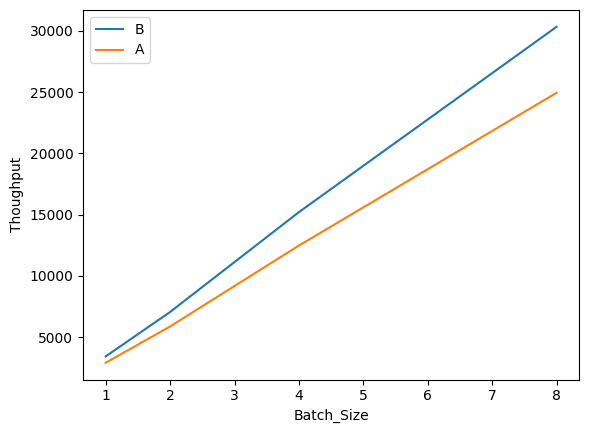

In [12]:
import matplotlib.pyplot as plt
B = (time_list - np.mean(time_list)) / np.std(time_list)
A = (time_list_after - np.mean(time_list_after)) / np.std(time_list_after)
plt.figure()
# 繪製 WCSS
# plt.plot(batch_size_list, B, label='B')
# plt.plot(batch_size_list, A, label='A')
plt.plot(batch_size_list[:4], time_list[:4], label='B')
plt.plot(batch_size_list[:4], time_list_after[:4], label='A')
# plt.plot(batch_size_list, time_list, label='B')
# plt.plot(batch_size_list, time_list_after, label='A')
# 添加圖例
plt.legend()
# 添加X軸和Y軸的標籤
plt.xlabel('Batch_Size')
plt.ylabel('Thoughput')

# 顯示圖
plt.show()

In [7]:
benchmark(trt_ts_module, input_shape=(1, 3, 32, 32), nruns=300, device=device, thoughput_list=time_list_after)

Warm up ...
Start timing ...
Iteration 10/300, avg batch time 0.86 ms
Iteration 20/300, avg batch time 0.86 ms
Iteration 30/300, avg batch time 0.85 ms
Iteration 40/300, avg batch time 0.85 ms
Iteration 50/300, avg batch time 0.85 ms
Iteration 60/300, avg batch time 0.85 ms
Iteration 70/300, avg batch time 0.85 ms
Iteration 80/300, avg batch time 0.85 ms
Iteration 90/300, avg batch time 0.85 ms
Iteration 100/300, avg batch time 0.85 ms
Iteration 110/300, avg batch time 0.85 ms
Iteration 120/300, avg batch time 0.85 ms
Iteration 130/300, avg batch time 0.85 ms
Iteration 140/300, avg batch time 0.85 ms
Iteration 150/300, avg batch time 0.85 ms
Iteration 160/300, avg batch time 0.85 ms
Iteration 170/300, avg batch time 0.85 ms
Iteration 180/300, avg batch time 0.85 ms
Iteration 190/300, avg batch time 0.85 ms
Iteration 200/300, avg batch time 0.85 ms
Iteration 210/300, avg batch time 0.85 ms
Iteration 220/300, avg batch time 0.85 ms
Iteration 230/300, avg batch time 0.85 ms
Iteration 240/

In [6]:
batch_size_list = [2**i for i in range(11)]
time_list = []
time_list_after = []

In [8]:
modelC = repvgg_model_convert(model)
modelC.eval()
modelC = modelC.to(device)
trt_ts_moduleC = torch_tensorrt.compile(modelC,
    inputs= [torch_tensorrt.Input((32, 3, 32, 32))],
    enabled_precisions= { torch.float} # Run with FP16
)


In [9]:
benchmark(trt_ts_moduleC, input_shape=(32, 3, 32, 32), nruns=300, device=device, thoughput_list=time_list)

Warm up ...
Start timing ...
Iteration 10/300, avg batch time 0.84 ms
Iteration 20/300, avg batch time 0.84 ms
Iteration 30/300, avg batch time 0.84 ms
Iteration 40/300, avg batch time 0.84 ms
Iteration 50/300, avg batch time 0.84 ms
Iteration 60/300, avg batch time 0.84 ms
Iteration 70/300, avg batch time 0.84 ms
Iteration 80/300, avg batch time 0.84 ms
Iteration 90/300, avg batch time 0.84 ms
Iteration 100/300, avg batch time 0.84 ms
Iteration 110/300, avg batch time 0.84 ms
Iteration 120/300, avg batch time 0.84 ms
Iteration 130/300, avg batch time 0.84 ms
Iteration 140/300, avg batch time 0.84 ms
Iteration 150/300, avg batch time 0.84 ms
Iteration 160/300, avg batch time 0.84 ms
Iteration 170/300, avg batch time 0.84 ms
Iteration 180/300, avg batch time 0.84 ms
Iteration 190/300, avg batch time 0.84 ms
Iteration 200/300, avg batch time 0.84 ms
Iteration 210/300, avg batch time 0.84 ms
Iteration 220/300, avg batch time 0.84 ms
Iteration 230/300, avg batch time 0.84 ms
Iteration 240/